In [867]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [868]:
detector = cv2.SIFT_create()

In [869]:
def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

In [870]:
def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.75):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
                
        #-- Get the keypoints from the good matches
        object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
        scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   
        
        
        #-- Get the corners of object
        h,w = imgs_dict[name]['shape'][0:2]
        object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        
        #-- Get the homography of object/scene
        H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC)

        #-- Get the corners of object in scene
        scene_corners = cv2.perspectiveTransform(object_corners, H)
        
        if len(good) > 50:
            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

In [871]:
def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(min(np.max(all_scene_corners[name], axis=0)[0][0], scene_img_bgr.shape[0]))
        y_max = int(min(np.max(all_scene_corners[name], axis=0)[0][1], scene_img_bgr.shape[1]))
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_image_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_image_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - 
                                                                 object_in_scene_img_mean_color)]))
        #if color_diff < 70:
        best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

In [872]:
def drawn_object_lines_in_scene(img_scene, all_scene_corners):
    for name in all_scene_corners.keys():
        scene_corners = all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=3)
    return img_scene

In [873]:
#-- bank of image
#object_imgs = ['0', '1', '11', '19', '24', '25', '26']
object_imgs = ['0', '11']
scene_imgs = ['e1', 'e2', 'e3', 'e4', 'e5']

In [874]:
detector = cv2.SIFT_create()
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [875]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [876]:
all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, 'e1', ratio_test=0.75)

In [877]:
len(all_good['11'])

110

In [878]:
all_scene_corners

{'0': array([[[  7.564372 ,   0.7714235]],
 
        [[  7.892311 , 439.04     ]],
 
        [[316.8406   , 423.47156  ]],
 
        [[318.8516   ,  -4.592219 ]]], dtype=float32),
 '11': array([[[294.8877  , -27.154718]],
 
        [[293.57373 , 363.6153  ]],
 
        [[594.2844  , 361.03577 ]],
 
        [[593.0185  , -26.177874]]], dtype=float32)}

In [879]:
best_all_scene_corners = check_best_color_matches(all_scene_corners , 'e1')
best_all_scene_corners

{'0': array([[[  7.564372 ,   0.7714235]],
 
        [[  7.892311 , 439.04     ]],
 
        [[316.8406   , 423.47156  ]],
 
        [[318.8516   ,  -4.592219 ]]], dtype=float32),
 '11': array([[[294.8877  , -27.154718]],
 
        [[293.57373 , 363.6153  ]],
 
        [[594.2844  , 361.03577 ]],
 
        [[593.0185  , -26.177874]]], dtype=float32)}

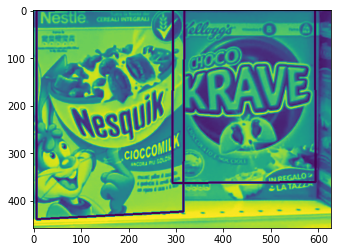

In [880]:
img_scene = cv2.imread('scenes/e1.png', cv2.IMREAD_GRAYSCALE)
img_scene = drawn_object_lines_in_scene(img_scene, best_all_scene_corners)

plt.imshow(img_scene)
plt.show()

In [881]:
object_color

array([129.52054902, 187.17959879, 196.9069641 ])

In [882]:
#-- color test

scene_img_bgr = cv2.imread('scenes/e1.png')
object_img_bgr = cv2.imread('models/11.jpg')  
scene_corners = all_scene_corners['11']

x_min = max(int(np.min(scene_corners, axis=0)[0][0]),0)
y_min = max(int(np.min(scene_corners, axis=0)[0][1]),0)
x_max = int(np.max(scene_corners, axis=0)[0][0])
y_max = int(np.max(scene_corners, axis=0)[0][1])


object_img_mean_color = object_image_bgr.mean(axis=0).mean(axis=0)
object_in_scene_img = scene_image_bgr[y_min:y_max,x_min:x_max]
object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))


color_diff
#plt.imshow(scene_image_bgr[y_min:y_max,x_min:x_max])

90.87804034780689

In [883]:
#-- center test

h,w = object_img_bgr.shape[0:2]
object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)



print(object_corners)
print(scene_corners)




[[[  0.   0.]]

 [[  0. 237.]]

 [[160. 237.]]

 [[160.   0.]]]
[[[294.8877   -27.154718]]

 [[293.57373  363.6153  ]]

 [[594.2844   361.03577 ]]

 [[593.0185   -26.177874]]]


In [884]:
np.linalg.norm(object_corners-scene_corners)

762.94904

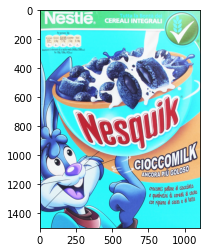

In [885]:
plt.imshow(object_image_bgr)

In [886]:
int(scene_image_bgr.shape[0])

458